# BEA 2024 Shared Task

## Automated Prediction of Item Difficulty and Item Response Time

### Problem Statement:  


Motivation
For standardized exams to be fair and valid, test items must meet certain criteria. One important criterion is that the questions should cover a wide range of difficulty levels to gather information about the abilities of test takers effectively. Additionally, it is essential to allocate an appropriate amount of time for each question: too little time can make the exam speeded, while too much time can make it inefficient. Typically, item difficulty and response time data are collected via a process called pretesting, where new items are embedded in live exams alongside scored items. While robust, this process of collecting item characteristics data is time-consuming and expensive. As noted by Settles et al. (2020), “This labor-intensive process often restricts the number of items that can feasibly be created, which in turn poses a threat to security: Items may be copied and leaked, or simply used too often”.

To address this challenge (also referred to as the “cold-start parameter estimation problem” (McCarthy et al., 2021)), there is growing interest in predicting item characteristics such as difficulty and response time based on the item text. Such estimates can be used to “jump-start” parameter estimation by exposing the item to a smaller sample of test-takers, or improve fairness by reducing the time variance for forms that include pretest items (Baldwin et al., 2020).

Due to difficulties with sharing exam data, efforts to advance the state-of-the-art in item parameter prediction have been fragmented and conducted in individual institutions, with no transparent evaluation on a publicly available dataset. In this Shared Task, we bridge this gap by sharing practice item content and characteristics from a high-stakes medical exam called the United States Medical Licensing Examination® (USMLE®) for the exploration of two topics: predicting item difficulty (Track 1) and item response time (Track 2) basured in seconds.

reference : https://sig-edu.org/sharedtask/2024


### Data

The data for the Shared Task consists of 667 previously used and now retired Multiple Choice Questions (MCQs) from USMLE Steps 1, 2 CK, and 3. The USMLE is a series of examinations (called Steps) to support medical licensure decisions in the United States that is developed by the National Board of Medical Examiners (NBME) and Federation of State Medical Boards (FSMB). An example practice item from the dataset is given in Table 1.

Q	A 65-year-old woman comes to the physician for a follow-up examination after blood pressure measurements were 175/105 mm Hg and 185/110 mm Hg 1 and 3 weeks ago, respectively. She has well-controlled type 2 diabetes mellitus. Her blood pressure now is 175/110 mm Hg. Physical examination shows no other abnormalities. Antihypertensive therapy is started, but her blood pressure remains elevated at her next visit 3 weeks later. Laboratory studies show increased plasma renin activity; the erythrocyte sedimentation rate and serum electrolytes are within the reference ranges. Angiography shows a high-grade stenosis of the proximal right renal artery; the left renal artery appears normal. Which of the following is the most likely diagnosis?
(A)	Atherosclerosis
(B)	Congenital renal artery hypoplasia
(C)	Fibromuscular dysplasia
(D)	Takayasu arteritis
(E)	Temporal arteritis
Table 1: An example of a practice item from the USMLE Step 1 Sample Test Questions at usmle.org

The part describing the case is referred to as stem, the correct answer is referred to as key, and the incorrect answer options are known as distractors. All items are MCQs that test medical knowledge and were written by experienced subject matter experts following a set of guidelines, stipulating adherence to a standard structure. These guidelines require avoidance of “window dressing” (extraneous material not needed to answer the item), “red herrings” (information designed to mislead the test-taker), and grammatical cues (e.g., correct answers that are longer or more specific than the other options). The goal of standardizing items in this manner is to produce items that vary in their difficulty and discriminating power due only to differences in the medical content they assess.

The items were administered within a standard nine-hour exam. For this shared task, the item characteristic data was derived from first-time examinees from accredited US and Canadian medical schools.

Each item is tagged with the following item characteristics:

<b> Item difficulty: </b> A measure of item difficulty where higher values indicate more difficult items.

<b> Time intensity: </b> arithmetic mean response time, measured in seconds, across all examinees who attempted a given item in a live exam. This includes all time spent on the item from the moment it is presented on the screen until the examinee moves to the next item, as well as any revisits.

The data is structured as follows:

ItemNum<\t>ItemStem_Text<\t>Answer__A<\t>Answer__B<\t>Answer__C<\t>Answer__D<\t>Answer__E<\t>Answer__F<\t>Answer__G<\t>Answer__H<\t>Answer__I<\t>Answer__J<\t>Answer_Key<\t>Answer_Text<\t>ItemType<\t>EXAM<\t>Difficulty<\t>Response_Time
ItemNum denotes the consecutive number of the item in the dataset (e.g., 1,2,3,4,5, etc).

<b> **ItemStem_Text** </b> contains the text data for the item stem (the part of the item describing the clinical case).

<b> Answer__A </b> contains the text for response option A

<b> Answer__B </b> contains the text for response option B

<b> Answer__C </b> contains the text for response option C.

(…)

<b> Answer__J </b> contains the text for response option J. For items that have fewer than J response options, the remaining columns are left blank. For example, if an item contains response options A to E, the fields for columns F to J are left blank for that item.

<b> Answer__Key </b> contains the letter of the correct answer for that item.

<b> Answer_Text </b> contains the text of the correct response for the item.

<b> ItemType </b> denotes whether the item contained an image (e.g., an x-ray image, picture of a skin lesion, etc.) or not. The value “Text” denotes text-only items that do not contain images and the value “PIX” denotes items that contain an image. Note that the images are not part of the dataset.

<b> EXAM </b> denotes the Step of the USMLE exam the item belongs to (Step 1, Step 2, or Step 3). For more information on the Steps of the USMLE see https://www.usmle.org/step-exams. <br>

<b> Difficulty </b> contains the item difficulty measure. Higher values indicate more difficult items. <br>

<b> Response_Time </b> contains the mean response time for the item measured in seconds. <br>

reference : https://sig-edu.org/sharedtask/2024

## Baseline:

#### 1. Data Cleaning / Preprocessing / Analysis

In [1]:
# Import libraries/frameworks
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
df = pd.read_excel( 'train_final.xlsx' )
test_data = pd.read_excel( 'test_final.xlsx' )
test_target = pd.read_excel( 'gold_final.xlsx' )
test_data = pd.merge( test_data, test_target, on = 'ItemNum' ) 
test_data.fillna( 0, inplace=True) 

df.head(3)

,ItemNum,ItemStem_Text,Answer__A,Answer__B,Answer__C,Answer__D,Answer__E,Answer__F,Answer__G,Answer__H,Answer__I,Answer__J,Answer_Key,Answer_Text,ItemType,EXAM,Difficulty,Response_Time
0,91,"Over 1 year, a study is conducted to assess th...",Case-control study,Crossover study,Open-labeled clinical trial,Randomized clinical trial,"Single-blind, randomized, controlled trial",NaN,NaN,NaN,NaN,NaN,C,Open-labeled clinical trial,Text,STEP 1,0.86,111.21
1,288,A previously healthy 52-year-old woman comes t...,Calcitriol production by activated macrophages,Local resorption of bone by metastases,Parathyroid hormone-related peptide secretion,Secretion of parathyroid hormone,Secretion of thyroid-stimulating hormone,NaN,NaN,NaN,NaN,NaN,A,Calcitriol production by activated macrophages,Text,STEP 1,0.44,83.94
2,160,A 42-year-old woman is brought to the emergenc...,CT scan of the abdomen,CT scan of the chest,Thoracoscopy,Laparotomy,Thoracotomy,NaN,NaN,NaN,NaN,NaN,D,Laparotomy,Text,STEP 2,0.64,87.82


As there are lot of records with null values, let's fill them up with 0

In [3]:
df.fillna(0, inplace=True)
df.head(2)

,ItemNum,ItemStem_Text,Answer__A,Answer__B,Answer__C,Answer__D,Answer__E,Answer__F,Answer__G,Answer__H,Answer__I,Answer__J,Answer_Key,Answer_Text,ItemType,EXAM,Difficulty,Response_Time
0,91,"Over 1 year, a study is conducted to assess th...",Case-control study,Crossover study,Open-labeled clinical trial,Randomized clinical trial,"Single-blind, randomized, controlled trial",0,0,0,0,0,C,Open-labeled clinical trial,Text,STEP 1,0.86,111.21
1,288,A previously healthy 52-year-old woman comes t...,Calcitriol production by activated macrophages,Local resorption of bone by metastases,Parathyroid hormone-related peptide secretion,Secretion of parathyroid hormone,Secretion of thyroid-stimulating hormone,0,0,0,0,0,A,Calcitriol production by activated macrophages,Text,STEP 1,0.44,83.94


In [4]:
cols = df.columns
cols

Index(['ItemNum', 'ItemStem_Text', 'Answer__A', 'Answer__B', 'Answer__C',
       'Answer__D', 'Answer__E', 'Answer__F', 'Answer__G', 'Answer__H',
       'Answer__I', 'Answer__J', 'Answer_Key', 'Answer_Text', 'ItemType',
       'EXAM', 'Difficulty', 'Response_Time'],
      dtype='object')

In [5]:
df.ItemType.value_counts()

ItemType
Text    416
PIX      50
Name: count, dtype: int64

In [6]:
df.EXAM.value_counts()

EXAM
STEP 1    190
STEP 2    154
STEP 3    122
Name: count, dtype: int64

As we are trying to build a model that determines the difficulty as well as response time specifically based on the semantics, let us just restrict our independent features to the ItemStem_Text, the multiple choices available and the answer. 

In [7]:
X_cols = ['ItemStem_Text', 'Answer__A', 'Answer__B', 'Answer__C', 'Answer__D', 'Answer__E', 'Answer__F', 'Answer__G', 'Answer__H', \
           'Answer__I', 'Answer__J', 'Answer_Text']
y_1 = df['Difficulty']
y_2 = df['Response_Time'] 

In [8]:
df[df['ItemNum'] == 606 ]

,ItemNum,ItemStem_Text,Answer__A,Answer__B,Answer__C,Answer__D,Answer__E,Answer__F,Answer__G,Answer__H,Answer__I,Answer__J,Answer_Key,Answer_Text,ItemType,EXAM,Difficulty,Response_Time
441,606,An 11-year-old girl is brought to the emergenc...,1,2,3,4,5,0,0,0,0,0,B,2,Text,STEP 1,0.42,63.21


There are some rows where the answer is in float or integer datatype, so , we will have to convert it to string so as to make it compatible with the embedding generator model.

#### 2. Dividing data into train and validation set

In [9]:
#X_train1, X_val1, y_train1, y_val1 = train_test_split( df[X_cols], y_1, test_size=0.1, random_state=1 )
#X_train2, X_val2, y_train2, y_val2 = train_test_split( df[X_cols], y_2, test_size=0.1, random_state=1 )

X_train = df[X_cols].astype('str')
X_test = test_data[X_cols].astype('str')
y_train1, y_train2 = y_1, y_2
y_test1, y_test2 = test_data[ 'Difficulty' ], test_data[ 'Response_Time' ]

In [10]:
X_train.shape, y_train1.shape, y_train2.shape, X_test.shape, y_test1.shape, y_test2.shape

((466, 12), (466,), (466,), (201, 12), (201,), (201,))

#### 3. Vectorizing input

In [11]:
# reference: https://huggingface.co/pritamdeka/S-PubMedBert-MS-MARCO
model = SentenceTransformer('pritamdeka/S-PubMedBert-MS-MARCO')
# example
len(model.encode( 'this is it' ))

768

In [12]:
def vectorizer( data ):
    data_vec = []
    for index, row in tqdm(data.iterrows()):
        ItemStem_Text_vec = model.encode( row['ItemStem_Text'] )
        cnt = 0
        temp_vec = np.zeros(768)
        for option in [ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J' ] : 
            if row[ 'Answer__' + option ] != 0 : 
                cnt += 1
                try: 
                    temp_vec += model.encode( row[ 'Answer__' + option ] )
                except: 
                    print(f"Error in {row[ 'Answer__' + option ]}")
                    cnt-=1
        temp_vec /= cnt
        Answer_vec = model.encode( row[ 'Answer_Text' ] )
    
        final_vec = ItemStem_Text_vec + temp_vec + Answer_vec 
        data_vec.append(final_vec)

    return np.array(data_vec)

In [13]:
X_train_1_vec, X_test_1_vec =  vectorizer(X_train), vectorizer(X_test)
X_train_1_vec.shape, X_test_1_vec.shape

466it [02:01,  3.84it/s]
201it [00:53,  3.73it/s]


((466, 768), (201, 768))

#### 4. Neural network - baseline model - predicting difficulty

In [14]:
tf.random.set_seed(1)

dl_model_1 = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(768,)),
      layers.Dense(1)
  ])

dl_model_1.compile( optimizer=tf.keras.optimizers.Adam(0.001),
                  loss = tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

dl_model_1.fit( X_train_1_vec, y_train1, epochs = 10 )

dl_model_1.summary()

Epoch 1/10
14/14 [==============================] - 2s 2ms/step - loss: 0.3524 - root_mean_squared_error: 0.5936
Epoch 2/10
14/14 [==============================] - 0s 1ms/step - loss: 0.3137 - root_mean_squared_error: 0.5601
Epoch 3/10
14/14 [==============================] - 0s 1ms/step - loss: 0.2368 - root_mean_squared_error: 0.4866
Epoch 4/10
14/14 [==============================] - 0s 1ms/step - loss: 0.2045 - root_mean_squared_error: 0.4522
Epoch 5/10
14/14 [==============================] - 0s 1ms/step - loss: 0.2009 - root_mean_squared_error: 0.4482
Epoch 6/10
14/14 [==============================] - 0s 2ms/step - loss: 0.2323 - root_mean_squared_error: 0.4820
Epoch 7/10
14/14 [==============================] - 0s 2ms/step - loss: 0.1756 - root_mean_squared_error: 0.4191
Epoch 8/10
14/14 [==============================] - 0s 2ms/step - loss: 0.1441 - root_mean_squared_error: 0.3796
Epoch 9/10
14/14 [==============================] - 0s 2ms/step - loss: 0.1355 - root_mean_squar

In [15]:
y1_predict = dl_model_1.predict(X_test_1_vec)
mean_squared_error( y_test1, y1_predict, squared=False ) 

2/2 [==============================] - 0s 6ms/step


0.42088477185159245

#### 5. Neural network - baseline model - predicting response time

In [16]:
dl_model_2 = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(768,)),
      layers.Dense(1)
  ])

dl_model_2.compile( optimizer=tf.keras.optimizers.Adam(0.001),
                  loss = tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

dl_model_2.fit( X_train_1_vec, y_train2, epochs = 25 )

dl_model_2.summary()

Epoch 1/25
14/14 [==============================] - 0s 2ms/step - loss: 7610.7280 - root_mean_squared_error: 87.2395
Epoch 2/25
14/14 [==============================] - 0s 2ms/step - loss: 6419.9683 - root_mean_squared_error: 80.1247
Epoch 3/25
14/14 [==============================] - 0s 2ms/step - loss: 5367.9526 - root_mean_squared_error: 73.2663
Epoch 4/25
14/14 [==============================] - 0s 2ms/step - loss: 4469.3042 - root_mean_squared_error: 66.8529
Epoch 5/25
14/14 [==============================] - 0s 2ms/step - loss: 3721.1514 - root_mean_squared_error: 61.0012
Epoch 6/25
14/14 [==============================] - 0s 2ms/step - loss: 3094.3862 - root_mean_squared_error: 55.6272
Epoch 7/25
14/14 [==============================] - 0s 1ms/step - loss: 2586.8848 - root_mean_squared_error: 50.8614
Epoch 8/25
14/14 [==============================] - 0s 1ms/step - loss: 2178.1841 - root_mean_squared_error: 46.6710
Epoch 9/25
14/14 [==============================] - 0s 2ms/step 

In [17]:
y2_predict = dl_model_2.predict(X_test_1_vec)
mean_squared_error( y_test2, y2_predict, squared=False ) 

2/2 [==============================] - 0s 2ms/step


24.236397691350845

### 6. Classical ML Algorithms

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [17]:
def find_best_classical_model(X_train,X_test, y_train, y_test):
    
    # Model 1 : Linear Regression 
    model_1_lr = LinearRegression()
    model_1_lr.fit(X_train, y_train)
    #y_predicted_1 = model_1_lr.predict(X_valid)
    #model_1_rmse = mean_squared_error( y_valid, y_predicted_1, squared=False ) 
    predicted_lr = model_1_lr.predict(X_test)
    test_rmse_lr = mean_squared_error( y_test, predicted_lr, squared=False )
    
    # Model 2 : Decision Tree classifier
    dtr = DecisionTreeRegressor(random_state=0)
    param_dict_2 = { "max_depth": [3,5] }
    model_2_dtr = GridSearchCV( dtr ,param_grid=param_dict_2, cv=3, refit = True)
    model_2_dtr.fit(X_train,y_train)
    #y_predicted_2 = model_2_dtr.predict(X_valid)
    #model_2_rmse = mean_squared_error( y_valid, y_predicted_2, squared=False ) 
    predicted_dt = model_2_dtr.predict(X_test)
    test_rmse_dt = mean_squared_error( y_test, predicted_dt, squared=False )

    # Model 3 : KNN
    knn = KNeighborsRegressor(weights="distance", metric= "minkowski", p = 2)
    param_dict_3 = { 'n_neighbors' : [3,5, 7] }
    model_3_knn = GridSearchCV(knn,param_grid=param_dict_3, cv=3 )
    model_3_knn.fit(X_train,y_train)
    #y_predicted_3 = model_3_knn.predict(X_valid)
    #model_3_rmse = mean_squared_error( y_valid, y_predicted_3, squared=False ) 
    predicted_knn = model_3_knn.predict(X_test)
    test_rmse_knn = mean_squared_error( y_test, predicted_knn, squared=False )

    # Model 4 : XGBoost
    regressor=xgb.XGBRegressor(eval_metric='rmse')
    param_dict_4 = {"max_depth": [3, 5], "n_estimators": [600, 700]}
    search = GridSearchCV(regressor, param_dict_4, cv=5).fit(X_train, y_train)
    regressor=xgb.XGBRegressor(n_estimators  = search.best_params_["n_estimators"],
                               max_depth     = search.best_params_["max_depth"],
                               eval_metric='rmse')
    regressor.fit(X_train, y_train)
    #y_predicted_4 = regressor.predict(X_valid)
    #model_4_rmse = mean_squared_error( y_valid, y_predicted_4, squared=False )
    predicted_xgb = regressor.predict(X_test)
    test_rmse_xgb = mean_squared_error( y_test, predicted_xgb, squared=False )

    # Model 5 : GBDT
    gbdt_regressor = GradientBoostingRegressor(random_state=0)
    param_dict_5 =  {"max_depth": [3,5], "n_estimators": [600, 700]}
    model_5_gbdt = GridSearchCV(gbdt_regressor, param_grid=param_dict_5, cv=3, refit=True )
    model_5_gbdt.fit(X_train,y_train)
    #y_predicted_5 = model_5_gbdt.predict(X_valid)
    #model_5_rmse = mean_squared_error( y_valid, y_predicted_5, squared=False )
    predicted_gbdt = model_5_gbdt.predict(X_test)
    test_rmse_dt = mean_squared_error( y_test, predicted_gbdt, squared=False )

    model_names = ["Linear Regression","Decision Trees","KNN","XGBoost","GBDT"]
    #rmse_scores = [ model_1_rmse, model_2_rmse, model_3_rmse, model_4_rmse, model_5_rmse ]
    test_rmse = [ test_rmse_lr, test_rmse_dt, test_rmse_knn, test_rmse_xgb, test_rmse_dt ]
    
    return model_names, test_rmse

In [18]:
%timeit
model_names, test_rmse_task1 = find_best_classical_model(X_train_1_vec, X_test_1_vec, y_train1, y_test1)   
model_names, test_rmse_task2 = find_best_classical_model(X_train_1_vec, X_test_1_vec, y_train2, y_test2)   

In [19]:
print(model_names)
print(test_rmse_task1)
print(test_rmse_task2)

['Linear Regression', 'Decision Trees', 'KNN', 'XGBoost', 'GBDT']
[0.6149357501461442, 0.32066804105765795, 0.3329348356026108, 0.31918916570115224, 0.32066804105765795]
[49.58395313603062, 29.927324648493776, 29.727154503708476, 29.657868451852718, 29.927324648493776]


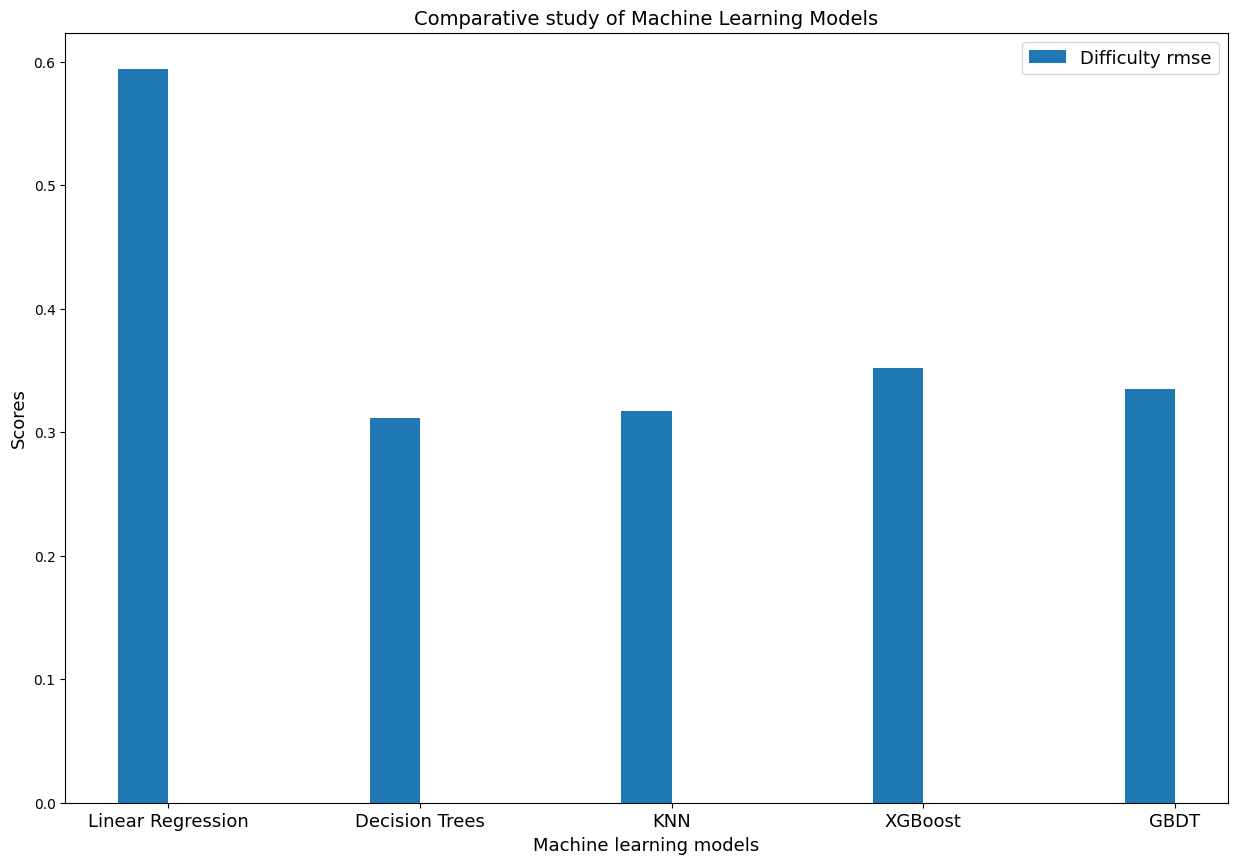

In [25]:
def plot_models_score_barplot(difficulty_rmse, resp_time_rmse, model_names):
    # Numbers of pairs of bars you want
    N = len(model_names)
    # Data on X-axis
    # Specify the values of blue bars (height)
    blue_bar = difficulty_rmse
    # Specify the values of orange bars (height)
    orange_bar = resp_time_rmse
    # Position of bars on x-axis
    ind = np.arange(N)
    # Figure size
    plt.figure(figsize=(15,10))
    # Width of a bar 
    width = 0.2       
    # Plotting
    plt.bar(ind, blue_bar , width, label='Difficulty rmse')
    #plt.bar(ind + width, orange_bar, width, label='Response time rmse')
    plt.xlabel('Machine learning models', fontsize=13)
    plt.ylabel('Scores', fontsize=13)
    plt.title('Comparative study of Machine Learning Models', fontsize=14)
    # xticks()
    # First argument - A list of positions at which ticks should be placed
    # Second argument -  A list of labels to place at the given locations
    plt.xticks(ind + width / 2,model_names, fontsize=13)
    # Finding the best position for legends and putting it
    plt.legend(loc='best', fontsize=13)
    plt.show()

plot_models_score_barplot(difficulty_rmse, resp_time_rmse, model_names)

In [23]:
import matplotlib.pyplot as plt

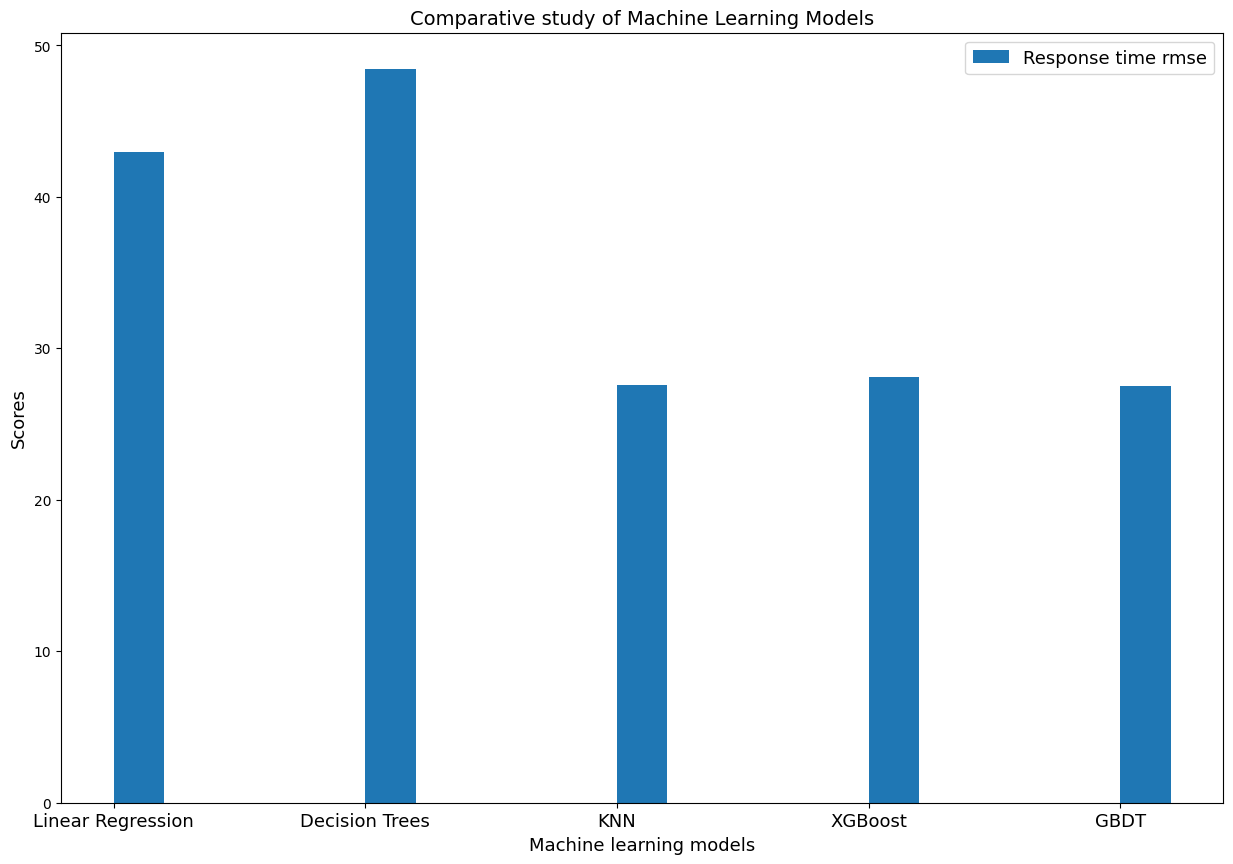

In [26]:
def plot_models_score_barplot(difficulty_rmse, resp_time_rmse, model_names):
    # Numbers of pairs of bars you want
    N = len(model_names)
    # Data on X-axis
    # Specify the values of blue bars (height)
    blue_bar = difficulty_rmse
    # Specify the values of orange bars (height)
    orange_bar = resp_time_rmse
    # Position of bars on x-axis
    ind = np.arange(N)
    # Figure size
    plt.figure(figsize=(15,10))
    # Width of a bar 
    width = 0.2       
    # Plotting
    #plt.bar(ind, blue_bar , width, label='Difficulty rmse')
    plt.bar(ind + width, orange_bar, width, label='Response time rmse')
    plt.xlabel('Machine learning models', fontsize=13)
    plt.ylabel('Scores', fontsize=13)
    plt.title('Comparative study of Machine Learning Models', fontsize=14)
    # xticks()
    # First argument - A list of positions at which ticks should be placed
    # Second argument -  A list of labels to place at the given locations
    plt.xticks(ind + width / 2,model_names, fontsize=13)
    # Finding the best position for legends and putting it
    plt.legend(loc='best', fontsize=13)
    plt.show()

plot_models_score_barplot(difficulty_rmse, resp_time_rmse, model_names)